In [1]:
import numpy as np
import torch
from torch import nn, optim
import torch.utils.data as Data
import math, copy, time
import matplotlib.pyplot as plt
import pandas as pd
from model.Transformer import Transformer
from torch.utils.data import DataLoader, Dataset, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
# init paramters
seed = 1
batch_size = 128
learning_rate = 1e-3

# steup using GPU or CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# setuo random seed
torch.manual_seed(seed)
time_step = 7

# Transformer Parameters
n_features = 7          # Embedding Size
d_ff = 500              # the number of hidden layer neurons from FeedForward neural network
d_k = d_v = 64          # dimension of K(=Q), V
n_layers = 6            # number of Encoder of Decoder Layer
n_heads = 8             # number of heads in Multi-Head Attention
tgt_vocab_size = 1

In [3]:
# load FinTech data
df = pd.read_csv('./data/FinTech.csv', encoding='utf-8')
df.head()
# Divide the data set into inputs and outputs
# df_input = df.drop(['Return'], axis=1).values
# df_ouput = df[['Return']].values

df_input = df.drop(['BTC_Price'], axis=1).values
df_ouput = df[['BTC_Price']].values

n_samples, n_features = df_input.shape
df_input.shape, df_ouput.shape
# Normalized data (mean:0, std:1)
X_scaler = StandardScaler()
Y_scaler = StandardScaler()
X_scaler = X_scaler.fit(df_input)
df_input = X_scaler.transform(df_input)
# X_test = X_scaler.transform(X_test)

Y_scaler = Y_scaler.fit(df_ouput)
df_ouput = Y_scaler.transform(df_ouput)
# Y_test = Y_scaler.transform(Y_test)
# X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

# built timeseries data for LSTM
X_data = np.zeros([n_samples-time_step+1, time_step, n_features])
Y_data = torch.Tensor(df_ouput[time_step-1:, :])
n_samples = X_data.shape[0]
X_data.shape, Y_data.shape

for i in range(n_samples):
    X_data[i, :, :] = df_input[i:i+time_step, :]
    
X_data = torch.Tensor(X_data)
X_data.shape, Y_data.shape

# split data to train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=0.25, random_state=1)
# make DataLoader
train_loader = DataLoader(TensorDataset(X_train, Y_train), batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, Y_test), batch_size, shuffle=False)
# for bath_id, batch_data in enumerate(train_loader):
#     print(bath_id, batch_data[0].shape)   # trian_data
#     print(bath_id, batch_data[1].shape)   # test_data

In [4]:
# built Transformer model
model = Transformer(n_heads, time_step, n_features, d_ff, n_layers, d_k, d_v).cuda()
criterion = nn.MSELoss()
# optimizer = optim.SGD(model.parameters(), lr=1e-5, momentum=0.99)
optimizer = optim.Adam(model.parameters(), lr=18*1e-5)

In [5]:
# 'R2 score'
def accuracy(preds, y):
    u = torch.sum(torch.square(y - preds))
    v = torch.sum(torch.square(y - torch.mean(y)))
    return 1 - (u/v)


def train(model, iterator, optimizer, criteon):

    avg_loss = []
    avg_acc = []
    model.train() 

    for batch_id, batch_data in enumerate(iterator):
        
        inputs, labels = batch_data
        dec_inputs = torch.zeros(labels.size(0), labels.size(-1), 1).long().cuda()
        inputs = inputs.to(device)
        labels = labels.to(device)
        pred, enc_self_attns, dec_self_attns, dec_enc_attns = model(inputs, dec_inputs)
        
#         print(pred.squeeze().shape, labels.shape)
        loss = criteon(pred.squeeze(), labels.squeeze())
        acc = accuracy(pred.squeeze(), labels.squeeze()).item()

        avg_loss.append(loss.item())
        avg_acc.append(acc)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_acc = np.array(avg_acc).mean()
    avg_loss = np.array(avg_loss).mean()
    return avg_loss, avg_acc
def predict(model, X):
    model.eval()
#     dec_inputs = torch.zeros(labels.size(0), labels.size(-1), 1).long().to(device)
    X.to(device)
    pred, enc_self_attns, dec_self_attns, dec_enc_attns = rnn(inputs, None)
    return pred


def evaluate(model, iterator, criteon):

    avg_loss = []
    avg_acc = []
    model.eval()
    att_weights = []
    with torch.no_grad():
        for batch_data in iterator:
            
            inputs, labels = batch_data
            dec_inputs = torch.zeros(labels.size(0), labels.size(-1), 1).long().cuda()
            inputs = inputs.to(device)
            labels = labels.to(device)
            pred, enc_self_attns, dec_self_attns, dec_enc_attns = model(inputs, dec_inputs)
            
#             att_weights.append(attention_weight.squeeze())
            loss = criteon(pred.squeeze(), labels.squeeze())
            acc = accuracy(pred, labels).item()

            avg_loss.append(loss.item())
            avg_acc.append(acc)

    avg_loss = np.array(avg_loss).mean()
    avg_acc = np.array(avg_acc).mean()
    return avg_loss, avg_acc, enc_self_attns, dec_self_attns, dec_enc_attns


In [6]:
#train and print model
best_valid_acc = float('-inf')

enc_self_attentions = []
dec_self_attentions = []
dec_enc_attentions = []

epochs = 300
for epoch in range(epochs):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    dev_loss, dev_acc, enc_self_attns, dec_self_attns, dec_enc_attns = evaluate(model, test_loader, criterion)

    end_time = time.time()

    epoch_mins, epoch_secs = divmod(end_time - start_time, 60)

    if dev_acc > best_valid_acc:
        best_valid_acc = dev_acc
        torch.save(model.state_dict(), 'transformer-model.pt')
    if epoch % 10 == 0 or epoch == epochs-1:
        print(f'Epoch: {epoch+1:2} | Epoch Time: {epoch_mins}m {epoch_secs:.2f}s')
        print(f'\tTrain Loss: {train_loss:.6f} | Train Acc: {train_acc*100:.5f}%')
        print(f'\t Val. Loss: {dev_loss:.6f} |  Val. Acc: {dev_acc*100:.5f}%')
    enc_self_attentions.append(enc_self_attns)
    dec_enc_attentions.append(dec_enc_attns)
    dec_self_attentions.append(dec_self_attns)

# #use srored model to predice 
# rnn.load_state_dict(torch.load("transformer-model.pt"))
# test_loss, test_acc, att_weights = evaluate(rnn, test_iterator, criteon)
# print(f'Test. Loss: {test_loss:.3f} |  Test. Acc: {test_acc*100:.2f}%')

Epoch:  1 | Epoch Time: 0.0m 0.80s
	Train Loss: 0.618961 | Train Acc: 36.82973%
	 Val. Loss: 0.379965 |  Val. Acc: 63.81471%
Epoch: 11 | Epoch Time: 0.0m 0.75s
	Train Loss: 0.207843 | Train Acc: 79.06462%
	 Val. Loss: 0.232586 |  Val. Acc: 78.45329%
Epoch: 21 | Epoch Time: 0.0m 0.77s
	Train Loss: 0.179351 | Train Acc: 81.80426%
	 Val. Loss: 0.196286 |  Val. Acc: 81.80850%
Epoch: 31 | Epoch Time: 0.0m 0.80s
	Train Loss: 0.190224 | Train Acc: 83.01007%
	 Val. Loss: 0.166664 |  Val. Acc: 84.62722%
Epoch: 41 | Epoch Time: 0.0m 0.77s
	Train Loss: 0.128599 | Train Acc: 87.03609%
	 Val. Loss: 0.162231 |  Val. Acc: 85.08929%
Epoch: 51 | Epoch Time: 0.0m 0.76s
	Train Loss: 0.146527 | Train Acc: 85.45434%
	 Val. Loss: 0.156277 |  Val. Acc: 85.60476%
Epoch: 61 | Epoch Time: 0.0m 0.80s
	Train Loss: 0.125882 | Train Acc: 87.81032%
	 Val. Loss: 0.137402 |  Val. Acc: 87.36048%
Epoch: 71 | Epoch Time: 0.0m 0.79s
	Train Loss: 0.108997 | Train Acc: 89.08923%
	 Val. Loss: 0.122571 |  Val. Acc: 88.81192%


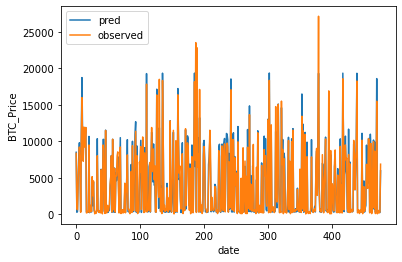

In [8]:
def predict(rnn, X):
    rnn.eval()
#     dec_inputs = torch.zeros(labels.size(0), labels.size(-1), 1).long().to(device)
    X = X.to(device)
    dec_inputs = torch.zeros(X.size(0), 1, 1).long().to(device)
    pred, enc_self_attns, dec_self_attns, dec_enc_attns = rnn(X, dec_inputs)
    return pred

# inverse normalized
pre = predict(model, X_test)
predY = Y_scaler.inverse_transform(pre.cpu().detach().numpy())
yytest = Y_scaler.inverse_transform(Y_test)
# plot prediction and true values
plt.plot(predY)
plt.plot(yytest)
plt.xlabel('date')
plt.ylabel('BTC_Price')
plt.legend(['pred','observed'])
plt.show()

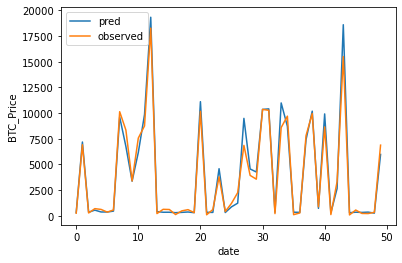

In [9]:
# plot prediction and true values
plt.plot(predY[-50:])
plt.plot(yytest[-50:])
plt.xlabel('date')
plt.ylabel('BTC_Price')
plt.legend(['pred','observed'])
plt.show()

In [10]:
# exchange timestep and n_features
new_X_data = X_data.transpose(1, 2)
new_X_data.shape
# split data to train and test set
X_train, X_test, Y_train, Y_test = train_test_split(new_X_data, Y_data, test_size=0.25, random_state=1)
# make DataLoader for train and evaluation
train_loader = DataLoader(TensorDataset(X_train, Y_train), batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, Y_test), batch_size, shuffle=False)

In [15]:
# built Transformer model
model = Transformer(n_heads, n_features, time_step, d_ff, n_layers, d_k, d_v).cuda()
criterion = nn.MSELoss()
# optimizer = optim.SGD(model.parameters(), lr=1e-5, momentum=0.99)
optimizer = optim.Adam(model.parameters(), lr=1*1e-4)

In [16]:
#train and print model
best_valid_acc = float('-inf')

enc_self_attentions = []
dec_self_attentions = []
dec_enc_attentions = []

epochs = 300
for epoch in range(epochs):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    dev_loss, dev_acc, enc_self_attns, dec_self_attns, dec_enc_attns = evaluate(model, test_loader, criterion)

    end_time = time.time()

    epoch_mins, epoch_secs = divmod(end_time - start_time, 60)

    if dev_acc > best_valid_acc:
        best_valid_acc = dev_acc
        torch.save(model.state_dict(), 'transformer-model.pt')
    if epoch % 10 == 0 or epoch == epochs-1:
        print(f'Epoch: {epoch+1:2} | Epoch Time: {epoch_mins}m {epoch_secs:.2f}s')
        print(f'\tTrain Loss: {train_loss:.6f} | Train Acc: {train_acc*100:.5f}%')
        print(f'\t Val. Loss: {dev_loss:.6f} |  Val. Acc: {dev_acc*100:.5f}%')
    enc_self_attentions.append(enc_self_attns)
    dec_enc_attentions.append(dec_enc_attns)
    dec_self_attentions.append(dec_self_attns)

# #use srored model to predice 
# rnn.load_state_dict(torch.load("transformer-model.pt"))
# test_loss, test_acc, att_weights = evaluate(rnn, test_iterator, criteon)
# print(f'Test. Loss: {test_loss:.3f} |  Test. Acc: {test_acc*100:.2f}%')

Epoch:  1 | Epoch Time: 0.0m 1.94s
	Train Loss: 0.964515 | Train Acc: -1.71227%
	 Val. Loss: 1.022212 |  Val. Acc: 1.88776%
Epoch: 11 | Epoch Time: 0.0m 1.84s
	Train Loss: 0.640020 | Train Acc: 35.46328%
	 Val. Loss: 0.660111 |  Val. Acc: 36.97850%
Epoch: 21 | Epoch Time: 0.0m 1.75s
	Train Loss: 0.526888 | Train Acc: 45.59707%
	 Val. Loss: 0.546753 |  Val. Acc: 48.02777%
Epoch: 31 | Epoch Time: 0.0m 1.47s
	Train Loss: 0.464020 | Train Acc: 52.70141%
	 Val. Loss: 0.448440 |  Val. Acc: 57.54457%
Epoch: 41 | Epoch Time: 0.0m 1.66s
	Train Loss: 0.372995 | Train Acc: 62.43360%
	 Val. Loss: 0.400100 |  Val. Acc: 62.10875%
Epoch: 51 | Epoch Time: 0.0m 1.68s
	Train Loss: 0.326730 | Train Acc: 67.41915%
	 Val. Loss: 0.365833 |  Val. Acc: 65.44910%
Epoch: 61 | Epoch Time: 0.0m 1.67s
	Train Loss: 0.278542 | Train Acc: 71.61288%
	 Val. Loss: 0.360525 |  Val. Acc: 65.99895%
Epoch: 71 | Epoch Time: 0.0m 1.70s
	Train Loss: 0.280563 | Train Acc: 71.73395%
	 Val. Loss: 0.349531 |  Val. Acc: 67.24225%
E

In [18]:
dev_loss, dev_acc, enc_self_attns, dec_self_attns, dec_enc_attns = evaluate(model, test_loader, criterion)

In [19]:
att = dec_enc_attns[-1].sum(dim=0).cpu()
pd.DataFrame(att.numpy().sum(axis=0).reshape(-1, 1))
df_coef = pd.DataFrame(columns=['variable', 'coefficient'])
df_coef['variable'] = df.columns[:-1]
df_coef['coefficient'] = att.numpy().sum(axis=0).reshape(-1, 1)
# df_coef['abs_coefficient'] = df_coef['coefficient'].abs()
# sort by absolute value of coefficient
pd.set_option('display.max_rows',None)
df_coef.sort_values(by=['coefficient'], ascending=False)

,variable,coefficient
0,Sentiment_24h,161.506866
6,DJCI_Gain_Rate,68.820053
1,DXYUSD_Gain_Rate,62.267284
8,SPY_Gain_Rate,61.749207
7,CrudeOil_Gain_Rate,59.475937
2,World_Index_Gain_Rate,57.082703
5,DBCCommodity_Gain_Rate,56.429596
9,VIX_Gain_Rate,56.242115
10,TNXTbill_Gain_Rate,54.021152
4,Silver_Gain_Rate,53.771309


In [24]:
# dy /dx
delta_x = 1e-6
y0 = predict(model, X_test)
y0

RuntimeError: CUDA out of memory. Tried to allocate 12.00 MiB (GPU 0; 15.78 GiB total capacity; 1.54 GiB already allocated; 7.19 MiB free; 1.70 GiB reserved in total by PyTorch)